In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import tqdm 
from PIL import Image
from sklearn.metrics import confusion_matrix
# import cv2 #pip install opencv-python==4.0.0.21
import glob
import pickle

import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

from skimage.io import imread, imshow
from skimage.transform import resize

import rasterio as rio
from rasterio.plot import show

import sys
sys.path.insert(1, '/Users/Willem/Werk/510/510_cloud_detection/scripts')

from build_CloudXNet import model_arch
import build_UNet
import utils
from metrics import *
from generator import DataGenerator

In [36]:
import gdal_polygonize

ModuleNotFoundError: No module named 'osgeo'

In [29]:
tif_path_2 = '/Users/Willem/Werk/510/output_test_5/data/4_prediction_scenes/resize_24_f1/maxar_clouds_small.tif'
tif_file_2 = rio.open(tif_path_2)
tif_small = tif_file_2.read(1)

In [35]:
tif_small

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [2]:
def preprocess_train_scene(dir_path, path_data, size=256):
    
    scene_name = os.path.split(dir_path)[1]

    all_tif_paths = utils.get_list_of_files(dir_path, ext='.TIF')
    all_anno_paths = utils.get_list_of_files(dir_path, ext='.img')

    rgb_train_dir = os.path.join(path_data, 'rgb_images/train/')
    rgb_val_dir = os.path.join(path_data, 'rgb_images/val/')
    rgb_test_dir = os.path.join(path_data, 'rgb_images/test/')

    anno_train_dir = os.path.join(path_data, 'annotations/train/')
    anno_val_dir = os.path.join(path_data, 'annotations/val/')
    anno_test_dir = os.path.join(path_data, 'annotations/test/')

    for m in tqdm(range(len(all_anno_paths))):
        # Read annotation
        an_path = all_anno_paths[m]
        anno_open = rio.open(an_path)
        anno_classes = anno_open.read(1)
        
        # Read rgb
        file_name = os.path.split(os.path.dirname(an_path))[1]
        reader_r = rio.open([x for x in all_tif_paths if file_name + '_B4'in x][0])
        reader_g = rio.open([x for x in all_tif_paths if file_name + '_B3'in x][0])
        reader_b = rio.open([x for x in all_tif_paths if file_name + '_B2'in x][0])

        # combine bands in array
        scaled_r = scale_pct(reader_r.read(1))
        scaled_g = scale_pct(reader_g.read(1))
        scaled_b = scale_pct(reader_b.read(1))
        rgb_array = np.stack([scaled_r, scaled_g, scaled_b], axis=2)

        #Binarize classes, thin clouds(192) & clouds(255) as class
        anno_bin = (np.logical_or(anno_classes == 192, anno_classes == 255)).astype(np.uint8)


        # pad image
        height = rgb_array.shape[0]
        width = rgb_array.shape[1]
        nr_tiles_h = (height//size + 1)
        nr_tiles_w = (width//size + 1)
        pad_height = nr_tiles_h*size - height
        pad_width = nr_tiles_w*size - width

        red = np.pad(rgb_array[:,:,0], pad_width = ((0,pad_height), (0,pad_width)))
        green = np.pad(rgb_array[:,:,1], pad_width = ((0,pad_height), (0,pad_width)))
        blue = np.pad(rgb_array[:,:,2], pad_width = ((0,pad_height), (0,pad_width)))
        anno_pad = np.pad(anno_bin, pad_width = ((0,pad_height), (0,pad_width)))

        full_img = np.stack((red, green, blue), axis=2)

        # Create all dirs for each file name
        save_train_dir_rgb = os.path.join(rgb_train_dir, scene_name, file_name) + '/'
        save_val_dir_rgb = os.path.join(rgb_val_dir, scene_name, file_name) + '/'
        save_test_dir_rgb = os.path.join(rgb_test_dir, scene_name, file_name) + '/'
        save_train_dir_an = os.path.join(anno_train_dir, scene_name, file_name) + '/'
        save_val_dir_an = os.path.join(anno_val_dir, scene_name, file_name) + '/'
        save_test_dir_an = os.path.join(anno_test_dir, scene_name, file_name) + '/'

        utils.ensure_directory_existance(save_train_dir_rgb)
        utils.ensure_directory_existance(save_val_dir_rgb)
        utils.ensure_directory_existance(save_test_dir_rgb)
        utils.ensure_directory_existance(save_train_dir_an)
        utils.ensure_directory_existance(save_val_dir_an)
        utils.ensure_directory_existance(save_test_dir_an)

        
        # loop over image and create size*size tiles with padding
        for i in range(nr_tiles_h):
            for j in range(nr_tiles_w): #might need to swap nr_tiles_h/w
                tile_rgb = full_img[i*size:(i+1)*size,j*size:(j+1)*size,:]#/255 they will get preprocessed
                tile_anno = anno_pad[i*size:(i+1)*size,j*size:(j+1)*size]
                
                # save all 256x256 images & annotations when the rgb image is not empty
                if np.sum(tile_rgb) > 1000:
                    save_img = Image.fromarray(tile_rgb, 'RGB')
                    save_anno = Image.fromarray(tile_anno)

                    random_number = random.randrange(10)
                    if random_number < 8: #save as train
                        save_img.save(save_train_dir_rgb + str(i*size) + '_' + str(j*size) + '.png')
                        save_anno.save(save_train_dir_an + str(i*size) + '_' + str(j*size) + '.png')
                    elif random_number == 8: #save as val
                        save_img.save(save_val_dir_rgb + str(i*size) + '_' + str(j*size) + '.png')
                        save_anno.save(save_val_dir_an + str(i*size) + '_' + str(j*size) + '.png')
                    else: #save as test
                        save_img.save(save_test_dir_rgb + str(i*size) + '_' + str(j*size) + '.png')
                        save_anno.save(save_test_dir_an + str(i*size) + '_' + str(j*size) + '.png')


    return


In [39]:
dataset = 'biome_input/' # name of folder 
path_data = '/Users/Willem/Werk/510/510_cloud_detection/' + dataset #/Users/Willem/Werk/510
print(path_data)

model_name = '0125v0_biome_50ep' # month, day, version, _model
path_save = '/notebooks/510_cloud_detection/saved_weigths/' + model_name
print(path_save)

/Users/Willem/Werk/510/510_cloud_detection/biome_input/
/notebooks/510_cloud_detection/saved_weigths/0125v0_biome_50ep


In [3]:
train_im = utils.get_list_of_files(os.path.join(path_data, 'rgb_images/train/'))
train_an = utils.get_list_of_files(os.path.join(path_data, 'annotations/train/'))
val_im = utils.get_list_of_files(os.path.join(path_data, 'rgb_images/val/'))
val_an = utils.get_list_of_files(os.path.join(path_data, 'annotations/val/'))

In [51]:
def pre_process_255(X):
    return X/255 #specify type?

In [52]:
train_gen = DataGenerator(train_im, train_an, pre_process_255, batch_size=8, width=256,
    height=256, augmentation=False)

val_gen = DataGenerator(val_im, val_an, pre_process_255, batch_size=8, width=256,
    height=256, augmentation=False)

In [ ]:
model = model_arch(input_rows=256, input_cols=256, num_of_channels=3, num_of_classes=1)
model.compile(optimizer = Adam(lr = 1e-4), loss = jacc_loss, metrics = [dice_score,'accuracy'])


In [ ]:
results = model.fit(train_gen, validation_data=val_gen, epochs=50, verbose=1)

# model.save_weights(path_save + '.h5')

# with open(path_save + '.pickle', 'wb') as handle:
#     pickle.dump(results_dict, handle)

Epoch 1/50
19/39 [=============>................] - ETA: 28s - loss: 0.8128 - dice_score: 0.3094 - accuracy: 0.3378

2022-01-20 08:58:22.705334: W tensorflow/core/common_runtime/bfc_allocator.cc:463] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.00GiB (rounded to 1073741824)requested by op model_2/concatenate_140/concat
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-01-20 08:58:22.705498: I tensorflow/core/common_runtime/bfc_allocator.cc:1013] BFCAllocator dump for GPU_0_bfc
2022-01-20 08:58:22.705526: I tensorflow/core/common_runtime/bfc_allocator.cc:1020] Bin (256): 	Total Chunks: 454, Chunks in use: 451. 113.5KiB allocated for chunks. 112.8KiB in use in bin. 51.2KiB client-requested in use in bin.
2022-01-20 08:58:22.705541: I tensorflow/core/common_runtime/bfc_allocator.cc:1020] Bin (512): 	Total Chunks: 129, Chunks in use: 126. 67.2KiB allocated for chunks. 65.8KiB in use in bin. 63.2KiB client-requested in use in bin.


ResourceExhaustedError:  OOM when allocating tensor with shape[8,512,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_2/concatenate_140/concat (defined at tmp/ipykernel_1027/2927412527.py:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_41569]

Function call stack:
train_function


(4, 256, 256, 3)


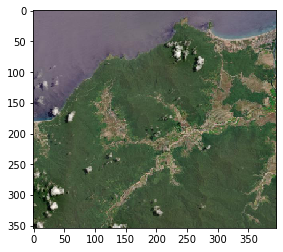

In [327]:
maxar_path_1 = '/Users/Willem/Werk/510/510_cloud_detection/geotiff_examples/maxar_clouds_small.tif'
maxar_path = '/Users/Willem/Werk/510/510_cloud_detection/geotiff_examples/maxar_clouds.tif'

downsized_img, all_tiles = create_tiles_from_tif(maxar_path_1)

print(all_tiles.shape)

show(downsized_img)

In [ ]:
model = model_arch(input_rows=256, input_cols=256, num_of_channels=3, num_of_classes=1)
checkpoint = '/Users/Willem/Werk/510/510_cloud_detection/saved_runs/0119v0_dataset_50ep.h5'
model.load_weights(checkpoint)

In [328]:
preds_test = model.predict(all_tiles, batch_size=2, verbose=1)
test_pred = (preds_test > 0.5).astype(int)

4/4 [==============================] - 7s 2s/sample


In [40]:
rgb_train_dir = os.path.join(path_data, 'rgb_images/train/')
rgb_val_dir = os.path.join(path_data, 'rgb_images/val/')
rgb_test_dir = os.path.join(path_data, 'rgb_images/test/')

anno_train_dir = os.path.join(path_data, 'annotations/train/')
anno_val_dir = os.path.join(path_data, 'annotations/val/')
anno_test_dir = os.path.join(path_data, 'annotations/test/')

In [42]:
rgb_train_dir

'/Users/Willem/Werk/510/510_cloud_detection/biome_input/rgb_images/train/'

In [ ]:
dir_path = '/Users/Willem/Werk/510/biome_urban'
biome_name = os.path.split(dir_path)[1]
size=256
empty_count = 0

all_tif_paths = utils.get_list_of_files(dir_path, ext='.TIF')
all_anno_paths = utils.get_list_of_files(dir_path, ext='.img')

all_anno_paths = all_anno_paths[0]

In [86]:
dir_path = '/Users/Willem/Werk/510/biome_urban'
scene_name = os.path.split(dir_path)[1]
size=256

all_tif_paths = utils.get_list_of_files(dir_path, ext='.TIF')
all_anno_paths = utils.get_list_of_files(dir_path, ext='.img')

for m in tqdm(range(len(all_anno_paths))):
    # Read annotation
    an_path = all_anno_paths[m]
    anno_open = rio.open(an_path)
    anno_classes = anno_open.read(1)
    
    # Read rgb
    file_name = os.path.split(os.path.dirname(an_path))[1]
    reader_r = rio.open([x for x in all_tif_paths if file_name + '_B4'in x][0])
    reader_g = rio.open([x for x in all_tif_paths if file_name + '_B3'in x][0])
    reader_b = rio.open([x for x in all_tif_paths if file_name + '_B2'in x][0])

    # combine bands in array
    scaled_r = scale_pct(reader_r.read(1))
    scaled_g = scale_pct(reader_g.read(1))
    scaled_b = scale_pct(reader_b.read(1))
    rgb_array = np.stack([scaled_r, scaled_g, scaled_b], axis=2)

    #Binarize classes, thin clouds(192) & clouds(255) as class
    anno_bin = (np.logical_or(anno_classes == 192, anno_classes == 255)).astype(np.uint8)


    # pad image
    height = rgb_array.shape[0]
    width = rgb_array.shape[1]
    nr_tiles_h = (height//size + 1)
    nr_tiles_w = (width//size + 1)
    pad_height = nr_tiles_h*size - height
    pad_width = nr_tiles_w*size - width

    red = np.pad(rgb_array[:,:,0], pad_width = ((0,pad_height), (0,pad_width)))
    green = np.pad(rgb_array[:,:,1], pad_width = ((0,pad_height), (0,pad_width)))
    blue = np.pad(rgb_array[:,:,2], pad_width = ((0,pad_height), (0,pad_width)))
    anno_pad = np.pad(anno_bin, pad_width = ((0,pad_height), (0,pad_width)))

    full_img = np.stack((red, green, blue), axis=2)

    # Create all dirs for each file name
    save_train_dir_rgb = os.path.join(rgb_train_dir, scene_name, file_name) + '/'
    save_val_dir_rgb = os.path.join(rgb_val_dir, scene_name, file_name) + '/'
    save_test_dir_rgb = os.path.join(rgb_test_dir, scene_name, file_name) + '/'
    save_train_dir_an = os.path.join(anno_train_dir, scene_name, file_name) + '/'
    save_val_dir_an = os.path.join(anno_val_dir, scene_name, file_name) + '/'
    save_test_dir_an = os.path.join(anno_test_dir, scene_name, file_name) + '/'

    utils.ensure_directory_existance(save_train_dir_rgb)
    utils.ensure_directory_existance(save_val_dir_rgb)
    utils.ensure_directory_existance(save_test_dir_rgb)
    utils.ensure_directory_existance(save_train_dir_an)
    utils.ensure_directory_existance(save_val_dir_an)
    utils.ensure_directory_existance(save_test_dir_an)

    
    # loop over image and create size*size tiles with padding
    for i in range(nr_tiles_h):
        for j in range(nr_tiles_w): #might need to swap nr_tiles_h/w
            tile_rgb = full_img[i*size:(i+1)*size,j*size:(j+1)*size,:]#/255 they will get preprocessed
            tile_anno = anno_pad[i*size:(i+1)*size,j*size:(j+1)*size]
            
            # save all 256x256 images & annotations when the rgb image is not empty
            if np.sum(tile_rgb) > 1000:
                save_img = Image.fromarray(tile_rgb, 'RGB')
                save_anno = Image.fromarray(tile_anno)

                random_number = random.randrange(10)
                if random_number < 8: #save as train
                    save_img.save(save_train_dir_rgb + str(i*size) + '_' + str(j*size) + '.png')
                    save_anno.save(save_train_dir_an + str(i*size) + '_' + str(j*size) + '.png')
                elif random_number == 8: #save as val
                    save_img.save(save_val_dir_rgb + str(i*size) + '_' + str(j*size) + '.png')
                    save_anno.save(save_val_dir_an + str(i*size) + '_' + str(j*size) + '.png')
                else: #save as test
                    save_img.save(save_test_dir_rgb + str(i*size) + '_' + str(j*size) + '.png')
                    save_anno.save(save_test_dir_an + str(i*size) + '_' + str(j*size) + '.png')


100%|██████████| 12/12 [04:58<00:00, 24.84s/it]


In [2]:
dir_path = '/Users/Willem/Werk/510/biome_urban'
biome_name = os.path.split(dir_path)[1]
size=256
empty_count = 0
m=0

all_tif_paths = utils.get_list_of_files(dir_path, ext='.TIF')
all_anno_paths = utils.get_list_of_files(dir_path, ext='.img')

an_path = all_anno_paths[m]
anno_open = rio.open(an_path)
anno_classes = anno_open.read(1)

# Read rgb
file_name = os.path.split(os.path.dirname(an_path))[1]
reader_r = rio.open([x for x in all_tif_paths if file_name + '_B4'in x][0])
reader_g = rio.open([x for x in all_tif_paths if file_name + '_B3'in x][0])
reader_b = rio.open([x for x in all_tif_paths if file_name + '_B2'in x][0])

# combine bands in array
rgb_array = np.stack([(reader_r.read(1)/256).astype('uint8'), (reader_g.read(1)/256).astype('uint8') ,(reader_b.read(1)/256).astype('uint8')], axis=2)


/opt/anaconda3/lib/python3.7/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [70]:
def scale_pct(x, pct=10):
    x_scaled = (x-np.nanpercentile(x, pct))/(np.nanpercentile(x, 100-pct) - np.nanpercentile(x, pct))
    x_scaled[x_scaled>1] = 1
    return (x_scaled*255).astype('uint8')

In [80]:
scaled_r = scale_pct(reader_r.read(1))

In [5]:
import seaborn as sns

sns.histplot(data=rgb_array[:,:,0], color="skyblue", label="Sepal Length", kde=True)
sns.histplot(data=rgb_array[:,:,1], color="red", label="Sepal Width", kde=True)

plt.legend() 
plt.show()

In [7]:
np.ndarray.flatten(rgb_array[:,:,0]).shape

(62184771,)

No handles with labels found to put in legend.


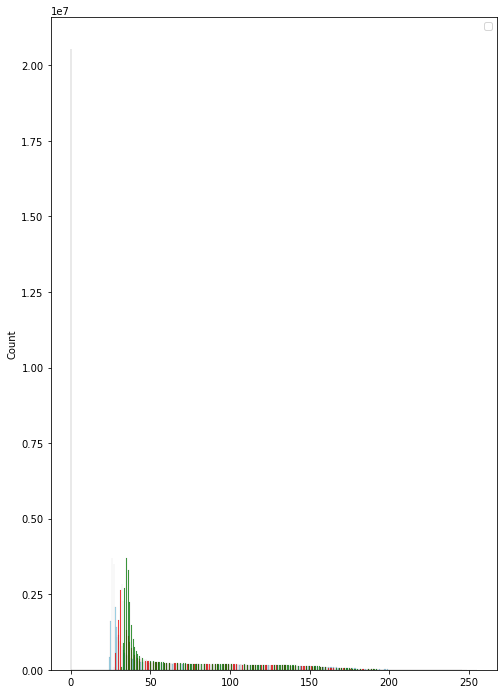

In [10]:
plt.figure(figsize=(12, 8))
sns.histplot(np.ndarray.flatten(rgb_array[:,:,0]), color="skyblue")
sns.histplot(np.ndarray.flatten(rgb_array[:,:,1]), color="red")
sns.histplot(np.ndarray.flatten(rgb_array[:,:,2]), color="green")
plt.legend() 
plt.show()

No handles with labels found to put in legend.


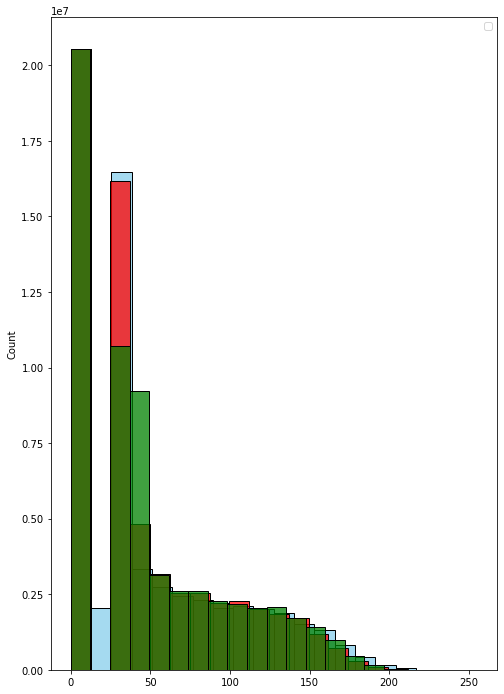

In [11]:
plt.figure(figsize=(12, 8))
sns.histplot(np.ndarray.flatten(rgb_array[:,:,0]), color="skyblue", bins = 20)
sns.histplot(np.ndarray.flatten(rgb_array[:,:,1]), color="red", bins = 20)
sns.histplot(np.ndarray.flatten(rgb_array[:,:,2]), color="green", bins = 20)
plt.legend() 
plt.show()




  0%|          | 0/32 [00:00<?, ?it/s]

0_1536 pct clouds: 0.3370208740234375


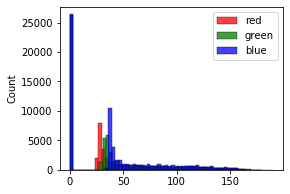

0_1792 pct clouds: 0.4476318359375


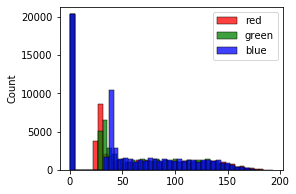

0_2048 pct clouds: 0.41497802734375


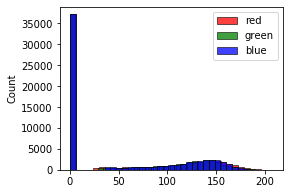

0_2304 pct clouds: 0.1283416748046875


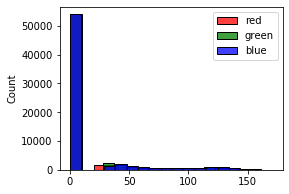

0_2560 pct clouds: 0.0045318603515625


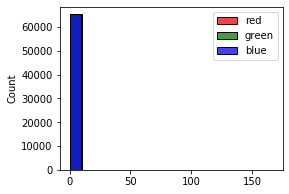




  3%|▎         | 1/32 [00:02<01:29,  2.87s/it]

256_1280 pct clouds: 0.0036773681640625


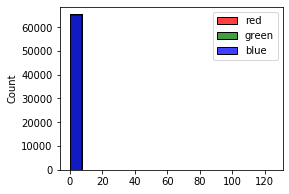

256_1536 pct clouds: 0.5413818359375


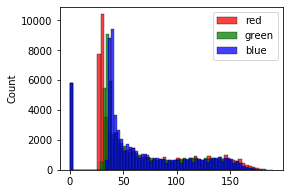

256_1792 pct clouds: 0.437591552734375


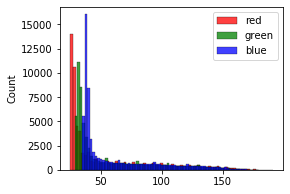

256_2048 pct clouds: 0.573883056640625


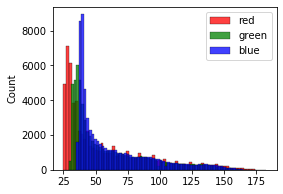

256_2304 pct clouds: 0.44989013671875


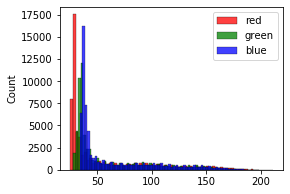

256_2560 pct clouds: 0.6337432861328125


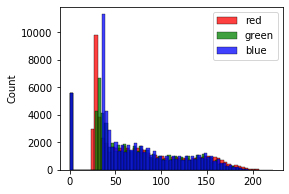

256_2816 pct clouds: 0.410247802734375


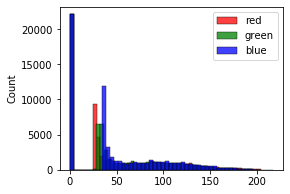

256_3072 pct clouds: 0.1009521484375


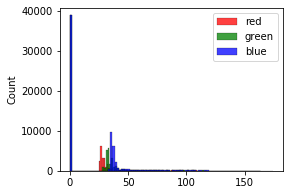

256_3328 pct clouds: 0.13177490234375


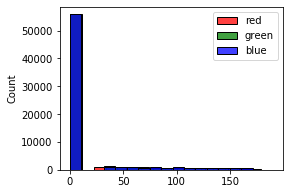

256_3584 pct clouds: 0.0008392333984375


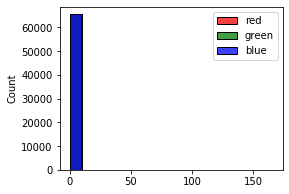




  6%|▋         | 2/32 [00:10<02:08,  4.30s/it]

512_1280 pct clouds: 0.157562255859375


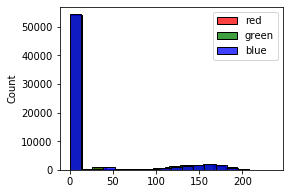

512_1536 pct clouds: 0.7671661376953125


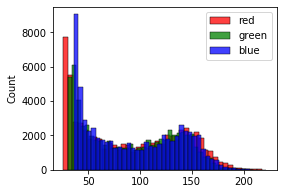

512_1792 pct clouds: 0.4174346923828125


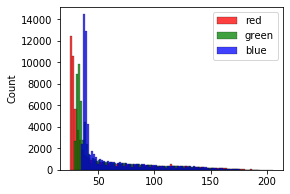

512_2048 pct clouds: 0.665283203125


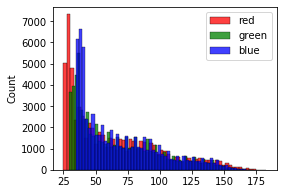

512_2304 pct clouds: 0.12286376953125


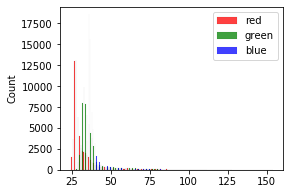

512_2560 pct clouds: 0.53631591796875


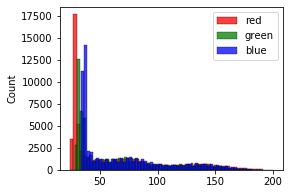

512_2816 pct clouds: 0.646942138671875


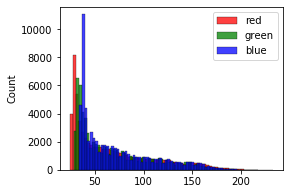

512_3072 pct clouds: 0.6369476318359375


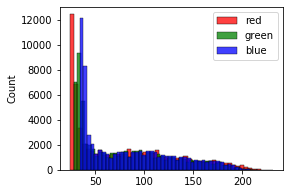

512_3328 pct clouds: 0.9036407470703125


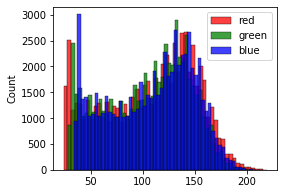

512_3584 pct clouds: 0.827728271484375


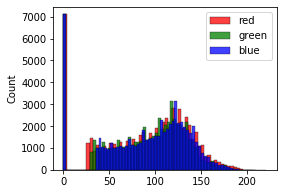

512_3840 pct clouds: 0.514892578125


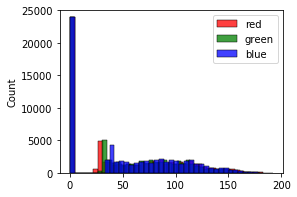

512_4096 pct clouds: 0.172210693359375


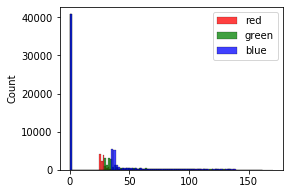

512_4352 pct clouds: 0.01324462890625


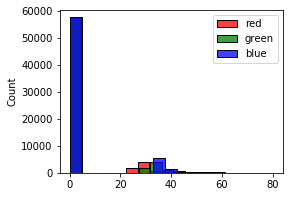




  9%|▉         | 3/32 [00:23<03:20,  6.90s/it]

768_1280 pct clouds: 0.329376220703125


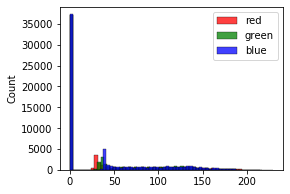

768_1536 pct clouds: 0.7530059814453125


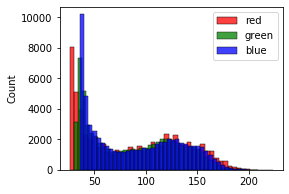

768_1792 pct clouds: 0.42376708984375


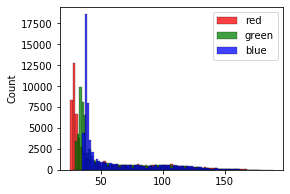

768_2048 pct clouds: 0.6840972900390625


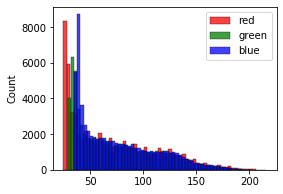

768_2304 pct clouds: 0.472381591796875


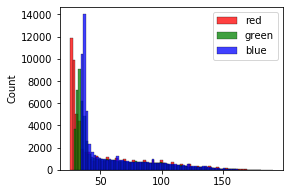

768_2560 pct clouds: 0.2482452392578125


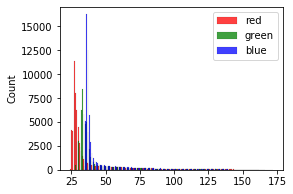

768_2816 pct clouds: 0.816925048828125


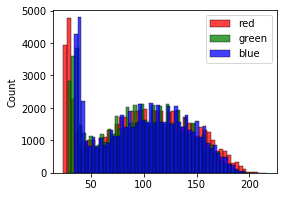

768_3072 pct clouds: 0.9106597900390625


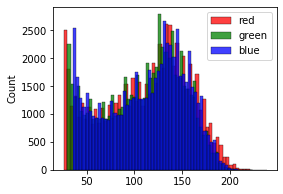

768_3328 pct clouds: 0.917724609375


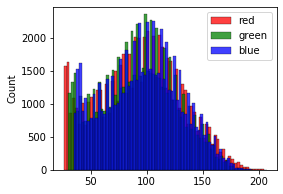

768_3584 pct clouds: 0.772705078125


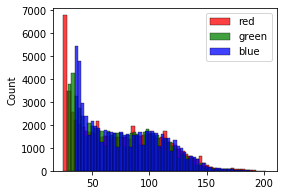

768_3840 pct clouds: 0.831512451171875


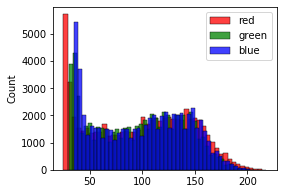

768_4096 pct clouds: 0.942169189453125


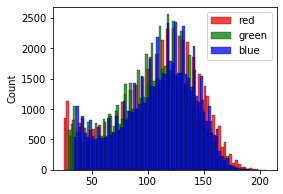

768_4352 pct clouds: 0.572967529296875


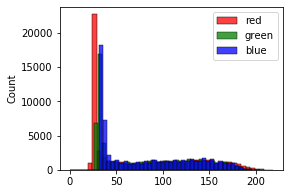

768_4608 pct clouds: 0.4408721923828125


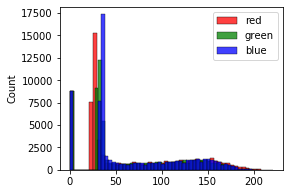

768_4864 pct clouds: 0.3566436767578125


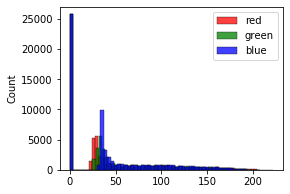

768_5120 pct clouds: 0.245452880859375


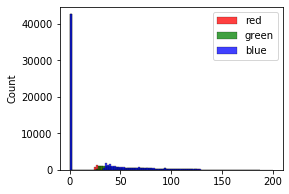

768_5376 pct clouds: 0.0286407470703125


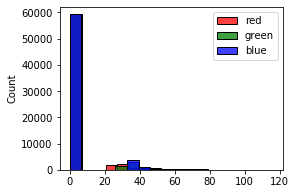




 12%|█▎        | 4/32 [00:38<04:23,  9.42s/it]

1024_1280 pct clouds: 0.1366729736328125


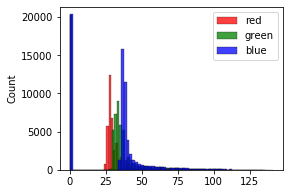

1024_1536 pct clouds: 0.24169921875


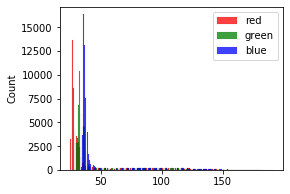

1024_1792 pct clouds: 0.4455108642578125


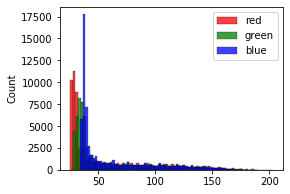

1024_2048 pct clouds: 0.7483978271484375


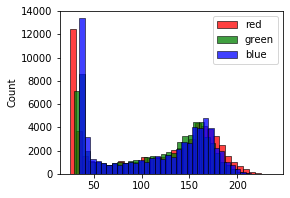

1024_2304 pct clouds: 0.9340667724609375


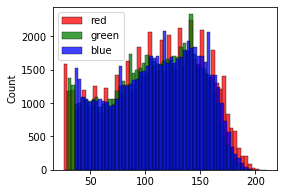

1024_2560 pct clouds: 0.9537353515625


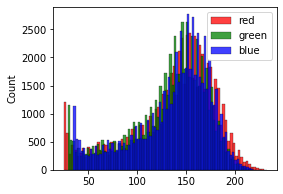

1024_2816 pct clouds: 0.8180694580078125


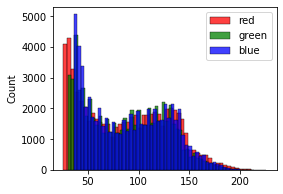

1024_3072 pct clouds: 0.530029296875


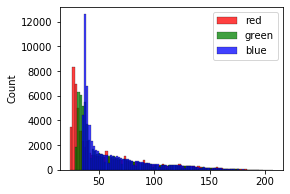

1024_3328 pct clouds: 0.46929931640625


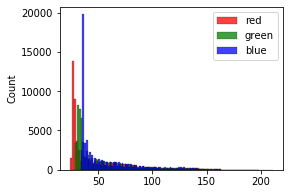

1024_3584 pct clouds: 0.7828369140625


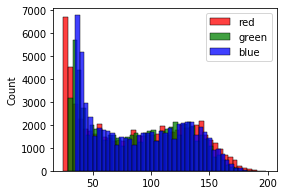

1024_3840 pct clouds: 0.68133544921875


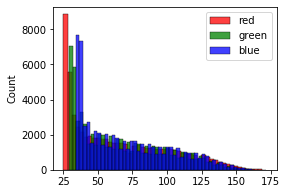

1024_4096 pct clouds: 0.5926513671875


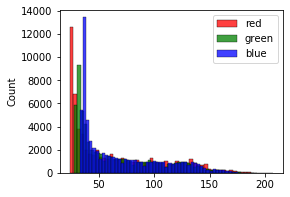

1024_4352 pct clouds: 0.2548065185546875


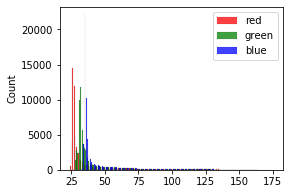

1024_4608 pct clouds: 0.5846710205078125


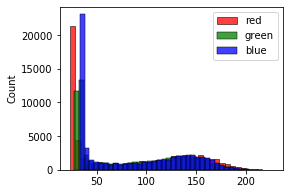

1024_4864 pct clouds: 0.2132110595703125


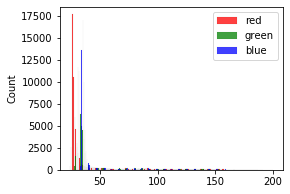

1024_5120 pct clouds: 0.320404052734375


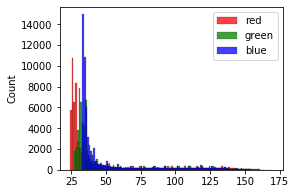

1024_5376 pct clouds: 0.7498626708984375


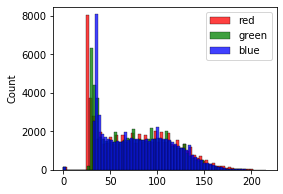

1024_5632 pct clouds: 0.63836669921875


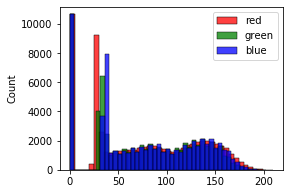

1024_5888 pct clouds: 0.5807647705078125


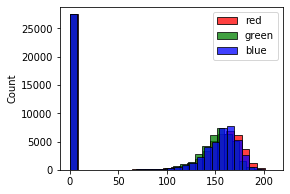

1024_6144 pct clouds: 0.323699951171875


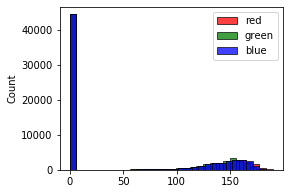

1024_6400 pct clouds: 0.053314208984375


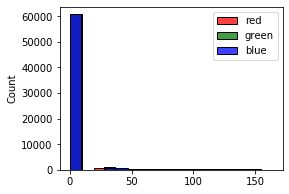




 16%|█▌        | 5/32 [01:02<06:10, 13.73s/it]

1280_1024 pct clouds: 0.0081024169921875


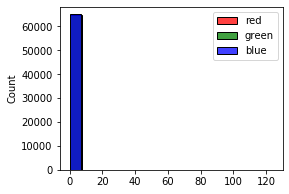

1280_1280 pct clouds: 0.4277801513671875


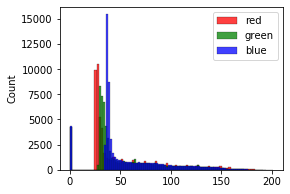

1280_1536 pct clouds: 0.4889984130859375


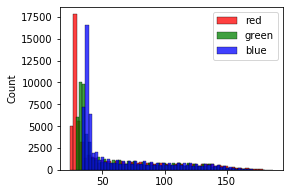

1280_1792 pct clouds: 0.7835693359375


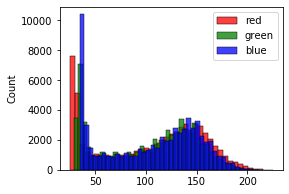

1280_2048 pct clouds: 0.579376220703125


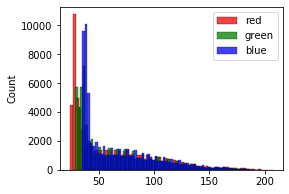

1280_2304 pct clouds: 0.739501953125


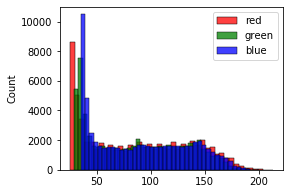

1280_2560 pct clouds: 0.8233795166015625


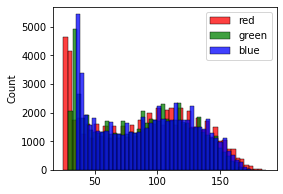

1280_2816 pct clouds: 0.748443603515625


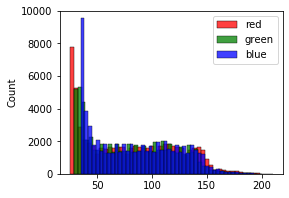

1280_3072 pct clouds: 0.7571258544921875


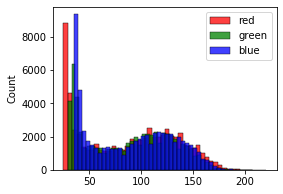

1280_3328 pct clouds: 0.6915435791015625


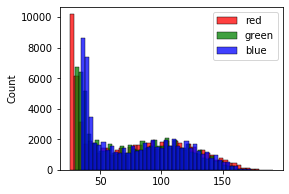

1280_3584 pct clouds: 0.647216796875


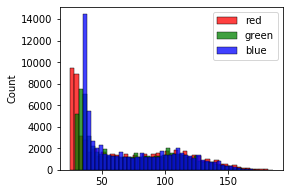

1280_3840 pct clouds: 0.8128662109375


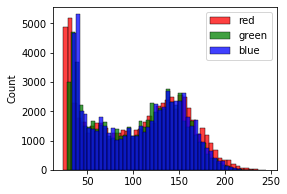

1280_4096 pct clouds: 0.8493194580078125


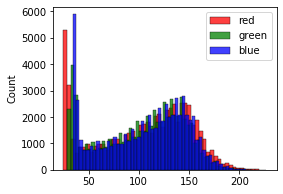

1280_4352 pct clouds: 0.8037261962890625


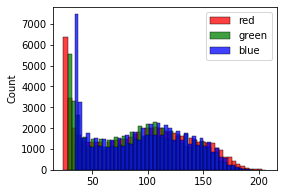

1280_4608 pct clouds: 0.6835479736328125


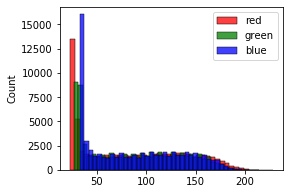

1280_4864 pct clouds: 0.604248046875


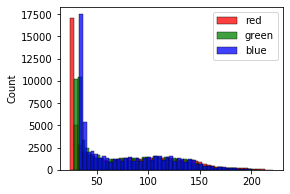

1280_5120 pct clouds: 0.186981201171875


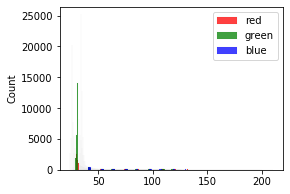

1280_5376 pct clouds: 0.74127197265625


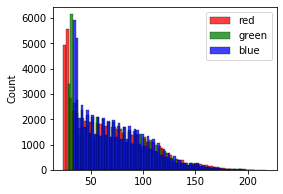

1280_5632 pct clouds: 0.735260009765625


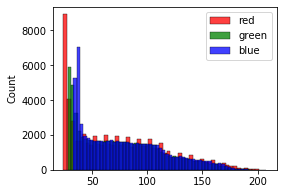

1280_5888 pct clouds: 0.8238525390625


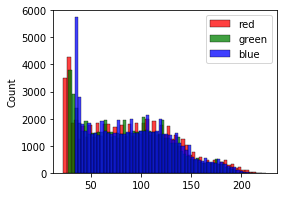

1280_6144 pct clouds: 0.87359619140625


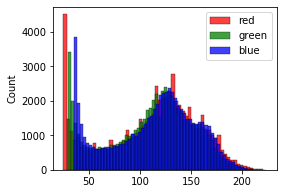

1280_6400 pct clouds: 0.818572998046875


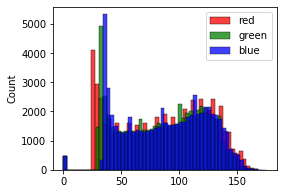

1280_6656 pct clouds: 0.2003936767578125


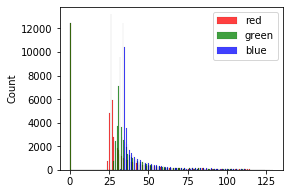

1280_6912 pct clouds: 0.06402587890625


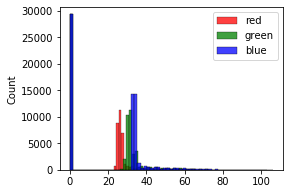

1280_7168 pct clouds: 0.096893310546875


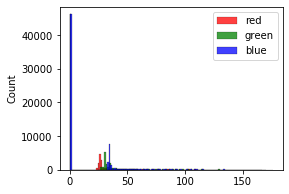

1280_7424 pct clouds: 0.0549774169921875


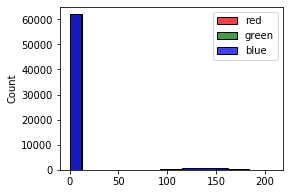




 19%|█▉        | 6/32 [01:28<07:30, 17.33s/it]

1536_1024 pct clouds: 0.1601104736328125


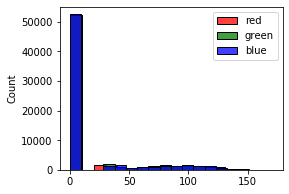

1536_1280 pct clouds: 0.5521697998046875


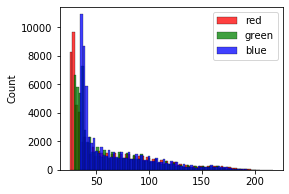

1536_1536 pct clouds: 0.5491943359375


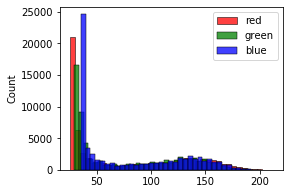

1536_1792 pct clouds: 0.3019561767578125


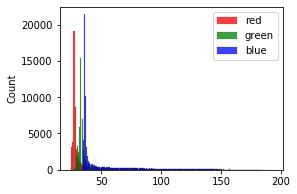

1536_2048 pct clouds: 0.6385650634765625


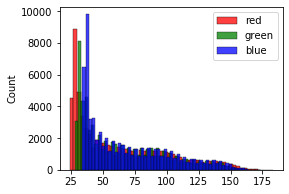

1536_2304 pct clouds: 0.3843536376953125


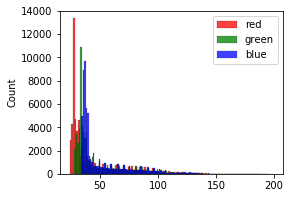

1536_2560 pct clouds: 0.5784454345703125


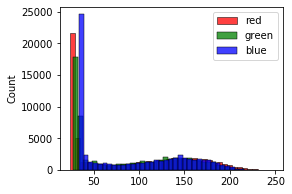

1536_2816 pct clouds: 0.5531158447265625


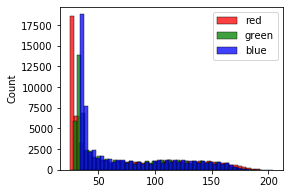

1536_3072 pct clouds: 0.2887725830078125


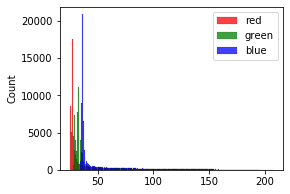

1536_3328 pct clouds: 0.9752960205078125


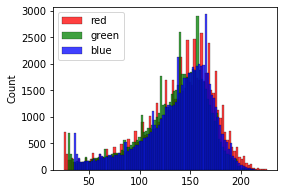

1536_3584 pct clouds: 0.977203369140625


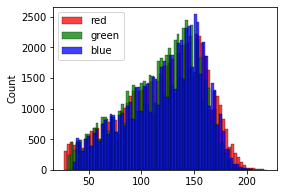

1536_3840 pct clouds: 0.5856781005859375


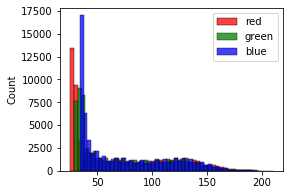

1536_4096 pct clouds: 0.3294677734375


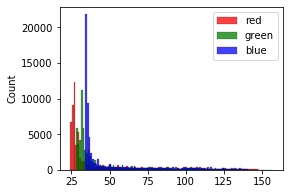

1536_4352 pct clouds: 0.7586822509765625


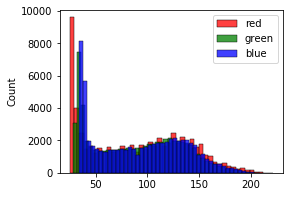

1536_4608 pct clouds: 0.70379638671875


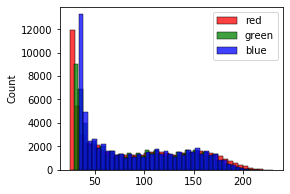

1536_4864 pct clouds: 0.3448486328125


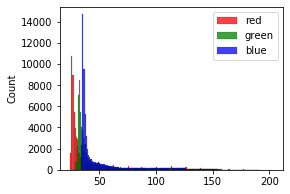

1536_5120 pct clouds: 0.2292327880859375


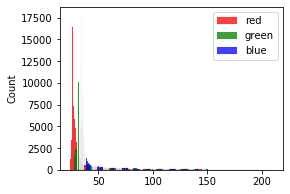

1536_5376 pct clouds: 0.5695648193359375


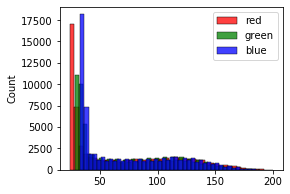

1536_5632 pct clouds: 0.85546875


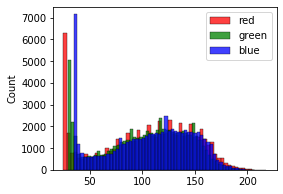

1536_5888 pct clouds: 0.96923828125


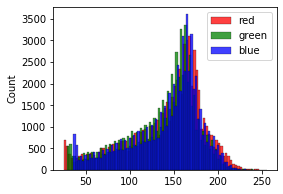

1536_6144 pct clouds: 1.0


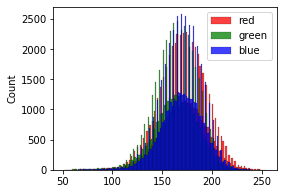

1536_6400 pct clouds: 0.971221923828125


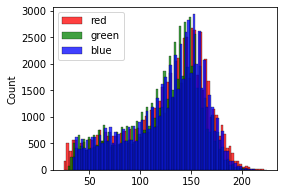

1536_6656 pct clouds: 0.500946044921875


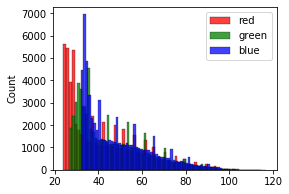

1536_6912 pct clouds: 0.4829864501953125


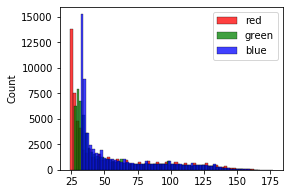

1536_7168 pct clouds: 0.36859130859375


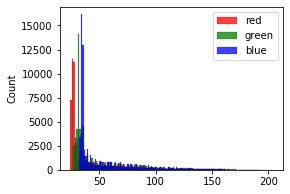

1536_7424 pct clouds: 0.8947906494140625


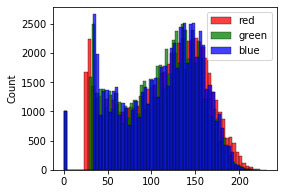

1536_7680 pct clouds: 0.0841217041015625


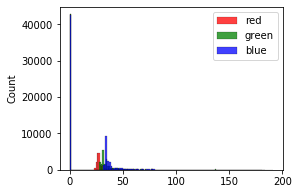




 22%|██▏       | 7/32 [01:57<08:41, 20.86s/it]

1792_1024 pct clouds: 0.1932830810546875


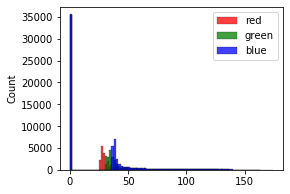

1792_1280 pct clouds: 0.786376953125


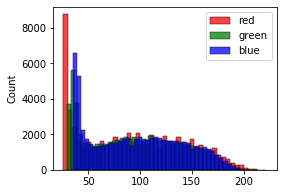

1792_1536 pct clouds: 0.8074951171875


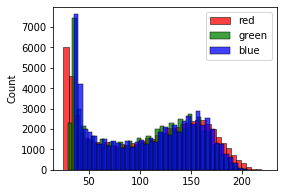

1792_1792 pct clouds: 0.673980712890625


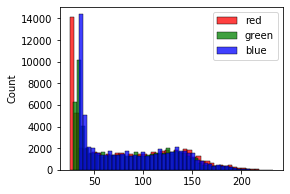

1792_2048 pct clouds: 0.6051788330078125


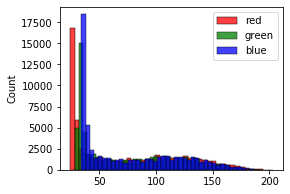

1792_2304 pct clouds: 0.5534210205078125


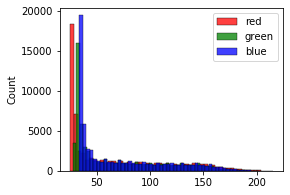

1792_2560 pct clouds: 0.664947509765625


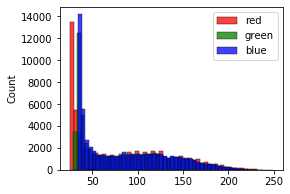

1792_2816 pct clouds: 0.5642242431640625


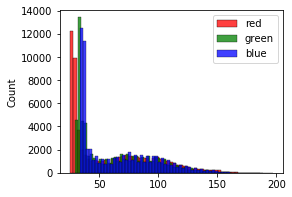

1792_3072 pct clouds: 0.5651702880859375


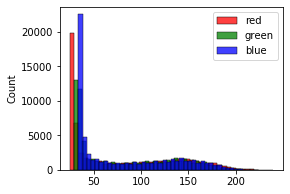

1792_3328 pct clouds: 0.7154388427734375


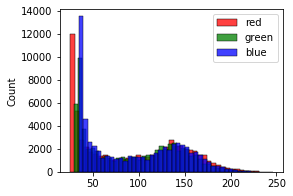

1792_3584 pct clouds: 0.797698974609375


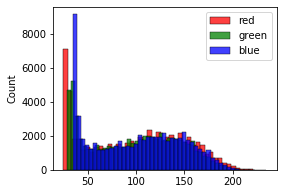

1792_3840 pct clouds: 0.6490478515625


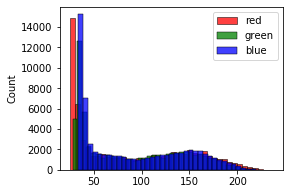

1792_4096 pct clouds: 0.7728424072265625


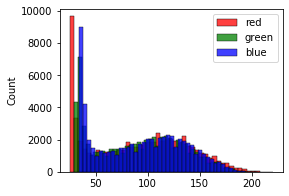

1792_4352 pct clouds: 0.83648681640625


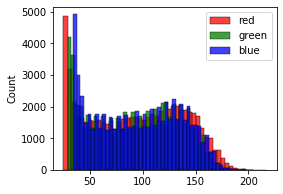

1792_4608 pct clouds: 0.8470306396484375


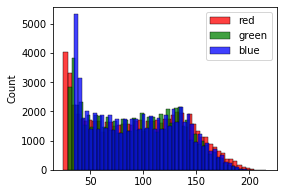

1792_4864 pct clouds: 0.8254852294921875


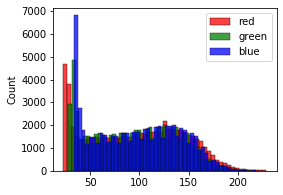

1792_5120 pct clouds: 0.710693359375


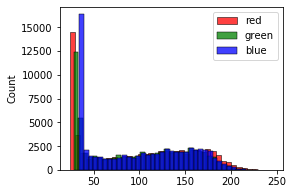

1792_5376 pct clouds: 0.980804443359375


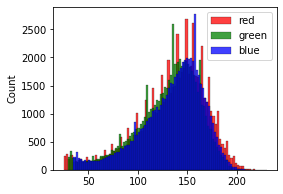

1792_5632 pct clouds: 0.9990692138671875


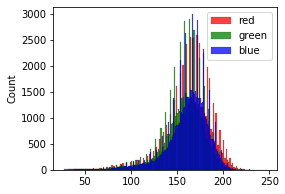

1792_5888 pct clouds: 0.9913787841796875


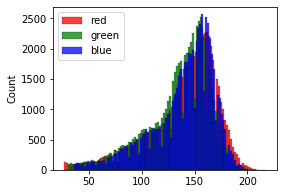

1792_6144 pct clouds: 0.9918212890625


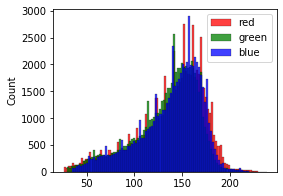

1792_6400 pct clouds: 0.9189453125


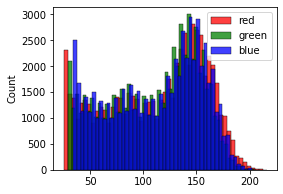

1792_6656 pct clouds: 0.3589019775390625


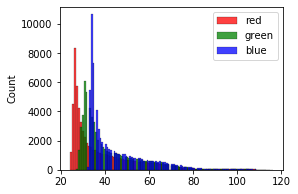

1792_6912 pct clouds: 0.3488616943359375


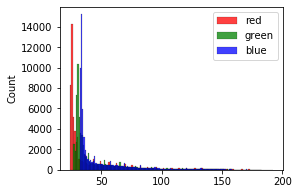

1792_7168 pct clouds: 0.746917724609375


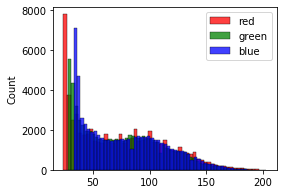

1792_7424 pct clouds: 0.8345184326171875


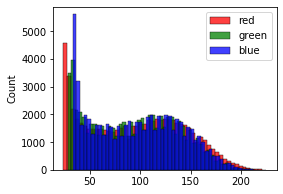

1792_7680 pct clouds: 0.1357879638671875


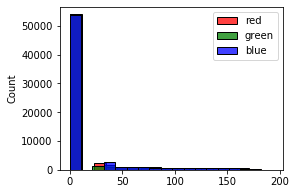




 25%|██▌       | 8/32 [02:20<08:38, 21.59s/it]

2048_1024 pct clouds: 0.3529510498046875


KeyboardInterrupt: 

In [30]:
anno_bin = (np.logical_or(anno_classes == 192, anno_classes == 255)).astype(np.uint8)

# pad image
height = rgb_array.shape[0]
width = rgb_array.shape[1]
nr_tiles_h = (height//size + 1)
nr_tiles_w = (width//size + 1)
pad_height = nr_tiles_h*size - height
pad_width = nr_tiles_w*size - width

red = np.pad(rgb_array[:,:,0], pad_width = ((0,pad_height), (0,pad_width)))
green = np.pad(rgb_array[:,:,1], pad_width = ((0,pad_height), (0,pad_width)))
blue = np.pad(rgb_array[:,:,2], pad_width = ((0,pad_height), (0,pad_width)))
anno_pad = np.pad(anno_bin, pad_width = ((0,pad_height), (0,pad_width)))

full_img = np.stack((red, green, blue), axis=2)


# loop over image and create size*size tiles with padding
for i in tqdm(range(nr_tiles_h)):
    for j in range(nr_tiles_w): #might need to swap nr_tiles_h/w
        tile_rgb = full_img[i*size:(i+1)*size,j*size:(j+1)*size,:]#/255 they will get preprocessed
        tile_anno = anno_pad[i*size:(i+1)*size,j*size:(j+1)*size]

        # save all 256x256 images & annotations when the rgb image is not empty
        if np.sum(tile_rgb) > 1000:
            
            print(str(i*size) + '_' + str(j*size), 'pct clouds:', np.sum(tile_anno)/tile_anno.size)
            
            plt.figure(figsize=(4, 3))
            sns.histplot(np.ndarray.flatten(tile_rgb[:,:,0]), color="red", label='red')
            sns.histplot(np.ndarray.flatten(tile_rgb[:,:,1]), color="green", label='green')
            sns.histplot(np.ndarray.flatten(tile_rgb[:,:,2]), color="blue", label='blue')
            plt.legend() 
            plt.show()


pct clouds: 0.437591552734375


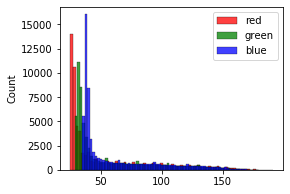

In [36]:
tile_rgb = full_img[256:512,1792:2048,:]
tile_anno = anno_pad[256:512,1792:2048]

print('pct clouds:', np.sum(tile_anno)/tile_anno.size)
plt.figure(figsize=(4, 3))
sns.histplot(np.ndarray.flatten(tile_rgb[:,:,0]), color="red", label='red')
sns.histplot(np.ndarray.flatten(tile_rgb[:,:,1]), color="green", label='green')
sns.histplot(np.ndarray.flatten(tile_rgb[:,:,2]), color="blue", label='blue')
plt.legend() 
plt.show()

In [40]:
np.sum(tile_rgb > 250)

0

In [41]:
save_img = Image.fromarray(tile_rgb, 'RGB')
save_anno = Image.fromarray(tile_anno)

save_img.save('test_tile.png')


In [10]:
biome_info = pd.read_csv('/Users/Willem/Werk/510/510_cloud_detection/biome_info.csv', header=1)
biome_pct = biome_info['Manual CCA'].str.rstrip('%').astype('float') / 100.0
np.mean(biome_pct)

0.49358214285714264

In [1]:
import glob
import os
from tqdm import tqdm 
from PIL import Image
import numpy as np
import rasterio as rio

import sys
sys.path.insert(1, '/Users/Willem/Werk/510/510_cloud_detection/scripts')
import utils

In [2]:
input_path = '/Users/Willem/Werk/510/510_cloud_detection/data/prediction_tiles'
run_name = 'test_name'
output_path = '/Users/Willem/Werk/510/510_cloud_detection/data/prediction_scenes'

size = 256
return_tif = True
resize_factor = 100

In [19]:
# load all scenes from run which we want to merge
all_runs = os.listdir(input_path)
run_to_merge = [x for x in all_runs if x == run_name]

# if run to merge is not specified, merge all runs (seperately)
if not run_to_merge:
    run_to_merge = all_runs
    
# loop over all runs to merge them
for run in run_to_merge:
    # get all scenes from this run and build output dir for this run
    all_scenes = os.listdir(os.path.join(input_path, run))
    utils.ensure_directory_existance(os.path.join(output_path, run))
    
    for i in tqdm(range(len(all_scenes))):
        # get all tiles from this scene 
        all_tiles = os.listdir(os.path.join(input_path, run, all_scenes[i]))
            
        # get dimensions of entire scene and create empty scene
        x_max = max([int(s.split('_')[0]) for s in all_tiles])
        y_max = max([int(s.split('.')[0].split('_')[1]) for s in all_tiles])
        predicted_scene = np.zeros((x_max+size, y_max+size), dtype=np.int8)
        
        for tile in all_tiles:
            # read in tile
            tile_array = np.asarray(Image.open(os.path.join(input_path, run, all_scenes[i], tile)))
            [x, y] = os.path.splitext(tile)[0].split('_')
            predicted_scene[int(x):(int(x)+size), int(y):(int(y)+size)] = tile_array.astype(rio.uint8) # divide by 255 to reduce output size
            
        # if we want to return a tif file, read in the input tif from input_scenes to get the crs
        if return_tif:
                # get input tif paths
                all_input_tif_paths = utils.get_list_of_files('/Users/Willem/Werk/510/510_cloud_detection/data/input_scenes', '.tif')
                tif_path_list = [x for x in all_input_tif_paths if os.path.splitext(os.path.basename(x))[0] == all_scenes[i]]

                if len(tif_path_list) == 0:
                    print('the input tif scene to obtain the crs cannot be found of this scene:', all_scenes[i])
                    break
                else:
                    if len(tif_path_list) > 1:
                        print('The scene', all_scenes[i], 'is found', len(tif_path_list), 'times in the input folder. Taking the crs from the first file')

                    # Enlarge predicted image back to original maxar size (takes a long time) and divide predictions by 255 to reduce output size
                    predicted_scene = (predicted_scene/255).astype(rio.uint8)
                    enlarged_pred = np.repeat(np.repeat(predicted_scene, resize_factor, axis=0), resize_factor, axis=1) 

                    open_tif = rio.open(tif_path_list[0])

                    with rio.open(os.path.join(output_path, run, all_scenes[i] + '.tif'), 'w', driver='GTiff', height=open_tif.height, 
                        width=open_tif.width, count=1, crs=open_tif.crs, dtype=rio.int8, transform=open_tif.transform) as dst:
                        dst.write(enlarged_pred[np.newaxis, 0:open_tif.height, 0:open_tif.width])

                    open_tif.close
            
        else:
            predicted_scene_out = Image.fromarray(predicted_scene)
            predicted_scene_out.save(os.path.join(output_path, run, all_scenes[i] + '.png'))
            
            




  0%|          | 0/2 [00:00<?, ?it/s]


 50%|█████     | 1/2 [01:19<01:19, 79.10s/it]


100%|██████████| 2/2 [01:45<00:00, 52.65s/it]


In [12]:
all_input_tif_paths = utils.get_list_of_files('/Users/Willem/Werk/510/510_cloud_detection/data/input_scenes', '.tif')
scene = 'maxar_clouds_small'
tif_path_list = [x for x in all_input_tif_paths if os.path.splitext(os.path.basename(x))[0] == scene]
tif_path = tif_path_list[0]


In [16]:
open_tif = rio.open(tif_path)
save_tif = rio.open(os.path.join(output_path, run, scene + '.tif'), 'w', driver='GTiff', height=open_tif.height, 
                    width=open_tif.width, count=1, crs=open_tif.crs, dtype=np.int8, transform=open_tif.transform)

In [ ]:
# # loop over image and create size*size tiles with padding
# for i in range(nr_tiles_h):
#     for j in range(nr_tiles_w):
#         tile_rgb = full_img[i*size:(i+1)*size,j*size:(j+1)*size,:]
#         save_img = Image.fromarray(tile_rgb, 'RGB')
#         save_img.save(os.path.join(scene_out_dir, str(i*size) + '_' + str(j*size) + '.png'))

In [ ]:
# rgb_train_dir = os.path.join(path_data, 'rgb_images/train/')
# rgb_val_dir = os.path.join(path_data, 'rgb_images/val/')
# rgb_test_dir = os.path.join(path_data, 'rgb_images/test/')

# anno_train_dir = os.path.join(path_data, 'annotations/train/')
# anno_val_dir = os.path.join(path_data, 'annotations/val/')
# anno_test_dir = os.path.join(path_data, 'annotations/test/')

# utils.ensure_directory_existance(rgb_train_dir)
# utils.ensure_directory_existance(rgb_val_dir)
# utils.ensure_directory_existance(rgb_test_dir)
# utils.ensure_directory_existance(anno_train_dir)
# utils.ensure_directory_existance(anno_val_dir)
# utils.ensure_directory_existance(anno_test_dir)

In [ ]:
# # dataset_38 tif's
# dataset_path = '/Users/Willem/Downloads/archive/'

# r_train_path = dataset_path + '/38-Cloud_training/train_red'
# g_train_path = dataset_path + '/38-Cloud_training/train_green'
# b_train_path = dataset_path + '/38-Cloud_training/train_blue'
# gt_train_path = dataset_path + '/38-Cloud_training/train_gt'
# csv_training_patches = '/Users/Willem/Downloads/archive/training_patches_38-cloud_nonempty.csv'

# r_train_files = os.listdir(r_train_path)
# g_train_files = os.listdir(g_train_path)
# b_train_files = os.listdir(b_train_path)
# gt_train_files = os.listdir(gt_train_path)

# df_non_empty = pd.read_csv(csv_training_patches)
# list_nonempty = list(df_non_empty['name'])


# for ind in tqdm(range(len(list_nonempty))): #len(list_nonempty)
    
#     # find same filepaths
#     non_empty_path = list_nonempty[ind]
#     file_r = [s for i, s in enumerate(r_train_files) if non_empty_path in s]
#     file_g = [s for i, s in enumerate(g_train_files) if non_empty_path in s]
#     file_b = [s for i, s in enumerate(b_train_files) if non_empty_path in s]
#     file_gt = [s for i, s in enumerate(gt_train_files) if non_empty_path in s]
    
#     if len(file_r) + len(file_g) + len(file_b) + len(file_gt) !=4:
#         print('Warning index:', ind)
    
#     # open all filepaths
#     reader_r = rio.open(os.path.join(r_train_path, file_r[0]))
#     reader_g = rio.open(os.path.join(g_train_path, file_g[0]))
#     reader_b = rio.open(os.path.join(b_train_path, file_b[0]))
#     reader_gt = rio.open(os.path.join(gt_train_path, file_gt[0]))
    
#     # combine bands and resize image
#     rgb_array = np.stack([(reader_r.read(1)/256).astype('uint8'), (reader_g.read(1)/256).astype('uint8') ,(reader_b.read(1)/256).astype('uint8')], axis=2)
#     rgb_array_256 = resize(rgb_array, (256, 256, 3), mode='constant', preserve_range=True).astype(np.uint8)
        
#     if rgb_array_256.shape != (256, 256, 3):
#         print('warning shape doesnt seem right', ind)
        
#     # Read annotation and resize
#     mask = reader_gt.read(1)
#     mask1 = resize(mask, (256, 256), order=0, mode='constant', preserve_range=True, anti_aliasing=False)
#     anno = mask1.astype(np.uint8)
    
#     save_img = Image.fromarray(rgb_array_256, 'RGB')
#     save_anno = Image.fromarray(anno)
# #     save_anno.save(anno_dir_path + str(int(id_)) + '.png')
    
#     random_number = random.randrange(10)
#     if random_number < 8: #save as train
#         save_img.save(rgb_train_dir + str(ind) + '.png')
#         save_anno.save(anno_train_dir + str(ind) + '.png')
#     elif random_number == 8: #save as val
#         save_img.save(rgb_val_dir + str(ind) + '.png')
#         save_anno.save(anno_val_dir + str(ind) + '.png')
#     else: #save as test
#         save_img.save(rgb_test_dir + str(ind) + '.png')
#         save_anno.save(anno_test_dir + str(ind) + '.png')
        
    
    
    
    

## Visualization dataset

In [ ]:
# dataset
# visualize training data, ground truth & rescaling

number_of_visualisations = 2
IMG_HEIGHT = 256
IMG_WIDTH = 256

random_indices = random.sample(range(0,350), number_of_visualisations)
print('random indices: ' + str(random_indices))
 
TRAIN_PATH_R = path_data + 'B4/train/'  #change path 
TRAIN_PATH_G = path_data + 'B3/train/'
TRAIN_PATH_B = path_data + 'B2/train/'

GT_PATH = path_data + 'BQA/train/'
 
for ind in random_indices:
    red    = Image.open(TRAIN_PATH_R + str(ind) + '.png').convert('L')
    green  = Image.open(TRAIN_PATH_G + str(ind) + '.png').convert('L')
    blue   = Image.open(TRAIN_PATH_B + str(ind) + '.png').convert('L')

    rgb = Image.merge("RGB",(red,green,blue))
    print('original image ' + str(ind) + ' of size ' + str(rgb.size))
    plt.imshow(rgb)
    plt.show()
    img_r = np.asarray(rgb) 
    img_r = resize(img_r, (IMG_HEIGHT, IMG_WIDTH, 3), mode='constant', preserve_range=True).astype('uint8')
    img_r_img = Image.fromarray(img_r, 'RGB') # own idea to realize an image plot
    print('resized image ' + str(ind) + ' of size ' + str(img_r_img.size))
    plt.imshow(img_r_img)
    plt.show()      

    gt = Image.open(GT_PATH + str(ind) + '.png')
    print('original gt ' + str(ind) + ' of size ' + str(gt.size))
    plt.imshow(gt)
    plt.show()
    gt_r = np.array(gt)[:,:,1] 
    gt_r = resize(gt_r, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True).astype('uint8')
    gt_r_img = Image.fromarray(gt_r, 'L') # own idea to realize an image plot
    print('resized gt ' + str(ind) + ' of size ' + str(gt_r_img.size))
    plt.imshow(gt_r_img)
    plt.show()




random indices: [166, 309]


NameError: name 'path_data' is not defined

In [ ]:
#number_of_visualisations = 2
IMG_HEIGHT = 384
IMG_WIDTH = 384

#random_indices = random.sample(range(0,10), number_of_visualisations)
#print('random indices: ' + str(random_indices))

TRAIN_FOLDER = path_data + '38-Cloud_training/' 
TRAIN_PATH_R = path_data + '38-Cloud_training/train_red'  #change path 
TRAIN_PATH_G = path_data + '38-Cloud_training/train_green'
TRAIN_PATH_B = path_data + '38-Cloud_training/train_blue'

GT_PATH = path_data + '38-Cloud_training/train_gt'

def get_input_image_names(list_names, directory_name, if_train=True):
    list_img = []
    list_msk = []
    list_test_ids = []

    for filenames in tqdm(list_names['name'], miniters=1000):
        nred = 'red_' + filenames
        nblue = 'blue_' + filenames
        ngreen = 'green_' + filenames

        if if_train:
            dir_type_name = "train"
            fl_img = []
            nmask = 'gt_' + filenames
            fl_msk = directory_name + '/train_gt/' + '{}.TIF'.format(nmask)
            list_msk.append(fl_msk)

        else:
            dir_type_name = "test"
            fl_img = []
            fl_id = '{}.TIF'.format(filenames)
            list_test_ids.append(fl_id)

        fl_img_red = directory_name + '/' + dir_type_name + '_red/' + '{}.TIF'.format(nred)
        fl_img_green = directory_name + '/' + dir_type_name + '_green/' + '{}.TIF'.format(ngreen)
        fl_img_blue = directory_name + '/' + dir_type_name + '_blue/' + '{}.TIF'.format(nblue)
        fl_img.append(fl_img_red)
        fl_img.append(fl_img_green)
        fl_img.append(fl_img_blue)

        list_img.append(fl_img)

    if if_train:
        return list_img, list_msk
    else:
        return list_img, list_test_ids

train_patches_csv_name = 'training_patches_38-Cloud.csv'
df_train_img = pd.read_csv(os.path.join(TRAIN_FOLDER, train_patches_csv_name))
train_img, train_msk = get_input_image_names(df_train_img, TRAIN_FOLDER, if_train=True)

NameError: name 'path_data' is not defined

In [ ]:
train_patches_csv_name_ne = 'training_patches_38-cloud_nonempty.csv'
df_train_img_ne = pd.read_csv(os.path.join(TRAIN_FOLDER, train_patches_csv_name_ne))

lst_non_empty = []
for patch in df_train_img['name']:
    lst_non_empty.append       (df_train_img_ne['name'].where(df_train_img_ne['name'] == patch).isna().sum())

print(100*5155 - sum(lst_non_empty))

non_empty = [i for i,x in enumerate(lst_non_empty) if x < 5155]

print(non_empty)

for index in non_empty:
    print(df_train_img['name'][index])

In [ ]:
def open_clean_bands(band_path):
    """A function that opens a Landsat band as an (rio)xarray object

    Parameters
    ----------
    band_path : list
        A list of paths to the tif files that you wish to combine.
        
    Returns
    -------
    An single xarray object with the Landsat band data.

    """
     
    return rxr.open_rasterio(band_path, masked=True).squeeze()

for ind in non_empty:
    # band_g = rxr.open_rasterio(train_img[ind][1], masked=True).squeeze()
    # band_g.shape
    # f, ax = plt.subplots()
    # band_g.plot.imshow(ax=ax, cmap='Greys_r')
    # ax.set_axis_off()
    # ax.set_title("Plot of Band Green")
    # Open all bands in a loop
    all_bands = []
    for i, aband in enumerate(train_img[ind]):
        all_bands.append(open_clean_bands(aband))
        # Assign a band number to the new xarray object
        all_bands[i]["band"]=i+1
    train_img_xr = xr.concat(all_bands, dim ='band')
    ep.plot_rgb(train_img_xr.values, rgb = [0, 1, 2], title='RGB Composite Image')
    plt.show()

## Generator

## Training model

In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
 
TRAIN_PATH_R = path_data + 'B4/train/'  #change path 
TRAIN_PATH_G = path_data + 'B3/train/'
TRAIN_PATH_B = path_data + 'B2/train/'
 
TEST_PATH_R = path_data + 'B4/test/'
TEST_PATH_G = path_data + 'B3/test/'
TEST_PATH_B = path_data + 'B2/test/'
 
X_train = np.zeros((350, IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((350, IMG_WIDTH, IMG_WIDTH), dtype=np.float32)
img = np.zeros((IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
 
tr=np.zeros(350)
 
for i in range(350):
       tr[i]=i;


In [ ]:
# # Visualize images

# rgb = Image.merge("RGB",(red,green,blue))
# print('original image ' + str(ind) + ' of size ' + str(rgb.size))
# plt.imshow(rgb)
# plt.show()
# img_r = np.asarray(rgb) 
# img_r = resize(img_r, (IMG_HEIGHT, IMG_WIDTH, 3), mode='constant', preserve_range=True).astype('uint8')
# img_r_img = Image.fromarray(img_r, 'RGB') # own idea to realize an image plot
# print('resized image ' + str(ind) + ' of size ' + str(img_r_img.size))
# plt.imshow(img_r_img)
# plt.show()      

# gt = Image.open(GT_PATH + str(ind) + '.png')
# print('original gt ' + str(ind) + ' of size ' + str(gt.size))
# plt.imshow(gt)
# plt.show()
# gt_r = np.array(gt)[:,:,1] 
# gt_r = resize(gt_r, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True).astype('uint8')
# gt_r_img = Image.fromarray(gt_r, 'L') # own idea to realize an image plot

In [ ]:
# train images
for n, id_ in tqdm(enumerate(tr),total=350):
    red    = Image.open(TRAIN_PATH_R + str(int(id_)) + '.png').convert('L')
    green  = Image.open(TRAIN_PATH_G + str(int(id_)) + '.png').convert('L')
    blue   = Image.open(TRAIN_PATH_B + str(int(id_)) + '.png').convert('L')

    rgb = Image.merge("RGB",(red,green,blue))
    img_b = np.asarray(rgb) 

    #img_r = imread(TRAIN_PATH_R + str(int(id_)) + '.png')[:,:,:IMG_CHANNELS]
    #img_g = imread(TRAIN_PATH_G + str(int(id_)) + '.png')[:,:,:IMG_CHANNELS]
    #img_b = imread(TRAIN_PATH_B + str(int(id_)) + '.png')[:,:,:IMG_CHANNELS]

    #img_r = resize(img_r, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
    #img_g = resize(img_g, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
    #img_b = resize(img_b, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)

    img_b = resize(img_b, (IMG_HEIGHT, IMG_WIDTH, 3), mode='constant', preserve_range=True)
    img_b= (img_b/255.0)
    #for i in range(256):
    #       img[i] = np.concatenate((img_r[i],img_g[i],img_b[i]), axis=1)

    X_train[n] = img_b.astype(np.float32)

    #mask = Image.open('/content/drive/My Drive/Colab Notebooks/dataset/BQA/train/' + str(int(102+id_)) + '.png').convert('L')
    mask = imread(path_data + 'BQA/train/' + str(int(id_)) + '.png')[:,:,1]
    mask1 = resize(mask, (IMG_HEIGHT, IMG_WIDTH), order=0, mode='constant', preserve_range=True, anti_aliasing=False)
    #mask1 = np.asarray(mask)
    #mask1 = resize(mask1, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
 
    Y_train[n] = (mask1==231).astype(int)


100%|██████████| 350/350 [00:58<00:00,  5.94it/s]


In [ ]:
#test images
nr_images = 36

te=np.zeros(nr_images)
for i in range(nr_images):
    te[i]=i;

# for test images 
X_test = np.zeros((nr_images, IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_test = np.zeros((nr_images, IMG_WIDTH, IMG_WIDTH), dtype=np.float32)
img = np.zeros((IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
sizes_test = []
 
for n, id_ in tqdm(enumerate(te),total=nr_images):
    if int(id_) <= 9:
        red    = Image.open(TEST_PATH_R + str(170+int(id_)) + '.png').convert('L')
        green  = Image.open(TEST_PATH_G + str(170+int(id_)) + '.png').convert('L')
        blue   = Image.open(TEST_PATH_B + str(170+int(id_)) + '.png').convert('L')
         
        rgb = Image.merge("RGB",(red,green,blue))
        img_b = np.asarray(rgb)  
        img_b = resize(img_b, (IMG_HEIGHT, IMG_WIDTH, 3), mode='constant', preserve_range=True)
        img_b=img_b/255.0

        X_test[n] = img_b

        mask = imread(path_data+ 'BQA/test/' + str(int(170+id_)) + '.png')[:,:,1]
        mask1 = resize(mask, (IMG_HEIGHT, IMG_WIDTH), order=0, mode='constant', preserve_range=True, anti_aliasing=False)
        
    else:
        red    = Image.open(TEST_PATH_R + str(314+int(id_)) + '.png').convert('L')
        green  = Image.open(TEST_PATH_G + str(314+int(id_)) + '.png').convert('L')
        blue   = Image.open(TEST_PATH_B + str(314+int(id_)) + '.png').convert('L')

        rgb = Image.merge("RGB",(red,green,blue))
        img_b = np.asarray(rgb)  
        img_b = resize(img_b, (IMG_HEIGHT, IMG_WIDTH, 3), mode='constant', preserve_range=True)
        img_b=img_b/255.0

        X_test[n] = img_b

        mask = imread(path_data+ 'BQA/test/' + str(int(314+id_)) + '.png')[:,:,1]
        mask1 = resize(mask, (IMG_HEIGHT, IMG_WIDTH), order=0, mode='constant', preserve_range=True, anti_aliasing=False)

    Y_test[n] = (mask1==231).astype(int)
    


100%|██████████| 36/36 [00:05<00:00,  6.07it/s]


In [ ]:
model = model_arch(input_rows=256, input_cols=256, num_of_channels=3, num_of_classes=1)
model.compile(optimizer = Adam(lr = 1e-4), loss = jacc_coef, metrics = [jacc_coef,'accuracy'])


NameError: name 'Input' is not defined

In [ ]:
results = model.fit(X_train, Y_train, validation_split=0.05, batch_size=2, epochs=50, verbose=1)

Epoch 1/50
166/166 [==============================] - 68s 373ms/step - loss: 0.1521 - jacc_coef: 0.1521 - accuracy: 0.8793 - val_loss: 0.3347 - val_jacc_coef: 0.3347 - val_accuracy: 0.6813
Epoch 2/50
166/166 [==============================] - 61s 367ms/step - loss: 0.0775 - jacc_coef: 0.0775 - accuracy: 0.9400 - val_loss: 0.3200 - val_jacc_coef: 0.3200 - val_accuracy: 0.6813
Epoch 3/50
166/166 [==============================] - 61s 367ms/step - loss: 0.0681 - jacc_coef: 0.0681 - accuracy: 0.9481 - val_loss: 0.3177 - val_jacc_coef: 0.3177 - val_accuracy: 0.6814
Epoch 4/50
166/166 [==============================] - 61s 367ms/step - loss: 0.0554 - jacc_coef: 0.0554 - accuracy: 0.9592 - val_loss: 0.1391 - val_jacc_coef: 0.1391 - val_accuracy: 0.9349
Epoch 5/50
166/166 [==============================] - 61s 366ms/step - loss: 0.0519 - jacc_coef: 0.0519 - accuracy: 0.9613 - val_loss: 0.2985 - val_jacc_coef: 0.2985 - val_accuracy: 0.7191
Epoch 6/50
166/166 [==============================] - 6

In [ ]:
# Save the entire model 
model.save(path_model) 

NameError: name 'model' is not defined

In [ ]:
results.history

NameError: name 'results' is not defined

## Evaluating model

In [ ]:
# # Load model

# test_model = tf.keras.models.load_model(path_model, compile=False)
# test_model.compile(optimizer = Adam(lr = 1e-4), loss = jacc_coef, metrics = [jacc_coef,'accuracy'])


# # test_model.summary()

# preds_test = test_model.predict(X_test, verbose=1)
# test_pred = (preds_test > 0.5).astype(int)


NameError: name 'tf' is not defined

In [ ]:
model.evaluate(X_test, Y_test, batch_size=2)

18/18 [==============================] - 1s 64ms/step - loss: 0.9824 - jacc_coef: 0.9824 - accuracy: 0.0305


[0.9824028015136719, 0.9824028015136719, 0.030534956604242325]

In [ ]:
preds_test = model.predict(X_test, batch_size=2, verbose=1)
test_pred = (preds_test < 0.5).astype(int)

18/18 [==============================] - 1s 59ms/step


RGB image


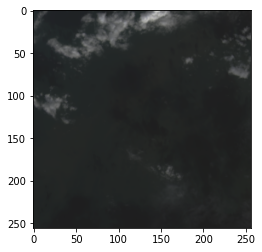

Ground truth


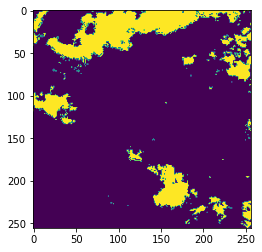

Prediction


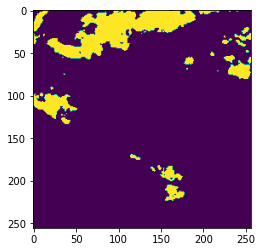

In [ ]:
image_id = 4

print('RGB image')
gt_img = X_test[image_id]
plt.imshow(gt_img)
plt.show()

print('Ground truth')
gt_img = Y_test[image_id].astype(int) 
plt.imshow(gt_img)
plt.show()

print('Prediction')
pred_img = test_pred[image_id][:,:,0]
plt.imshow(pred_img)
plt.show()

In [ ]:
mask = imread(path_data + 'BQA/train/' + str(int(image_id)) + '.png')[:,:,1]
mask1 = resize(mask, (IMG_HEIGHT, IMG_WIDTH), order=0, mode='constant', preserve_range=True, anti_aliasing=False)
 

In [ ]:
(mask1 == 231).astype(int)

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [ ]:
def mean_iou(gt, mask):
    gt = gt.flatten()
    mask = mask.flatten()
    tn,fp,fn,tp = confusion_matrix(gt,mask).ravel()
    iou = tp/(tp+fn+fp)
    iou_n = tn/(tn+fn+fp)
    rec = 0.5 * iou + 0.5 * iou_n
    return(rec)

def fw_iou(gt, mask):
    gt = gt.flatten()
    mask = mask.flatten()
    tn,fp,fn,tp = confusion_matrix(gt,mask).ravel()
    iou = tp/(tp+fn+fp)
    iou_n = tn/(tn+fn+fp)
    cloud_weight = (tp + fp)/(tn + fp + fn + tp)
    rec = cloud_weight * iou + (1 - cloud_weight) * iou_n
    return(rec)

sum = 0
for i in range(len(Y_test)):
  #print('Jaccard Index ' + str(i) + ' ' + str(jaccard(Y_test[i],preds_test_t[i])))
  sum = sum + mean_iou(Y_test[i],test_pred[i])
mIoU = sum/len(Y_test)

sum = 0
for i in range(len(Y_test)):
  #print('Jaccard Index ' + str(i) + ' ' + str(jaccard(Y_test[i],preds_test_t[i])))
  sum = sum + fw_iou(Y_test[i],test_pred[i])
fwIoU = sum/len(Y_test)

print('Mean IoU: ' + str(mIoU))
print('Frequency weighted IoU: ' + str(fwIoU))


Mean IoU: 0.8635373612575186
Frequency weighted IoU: 0.9438622378879216


In [ ]:
from sklearn.metrics import confusion_matrix

def precision(gt,mask):
    gt = gt.flatten()
    mask = mask.flatten()
    tn,fp,fn,tp = confusion_matrix(gt,mask).ravel()
    prec = tp/(tp+fp)
    return(prec)

####recall---
def recall(gt,mask):
    gt = gt.flatten()
    mask = mask.flatten()
    tn,fp,fn,tp = confusion_matrix(gt,mask).ravel()
    rec = tp/(tp+fn)
    return(rec)

###f1 score--

def f1_score(prec,rec):
    f1 = 2*(prec*rec)/(prec+rec)
    return f1

  ### jaccard 
def jaccard(gt,mask):
    gt = gt.flatten()
    mask = mask.flatten()
    tn,fp,fn,tp = confusion_matrix(gt,mask).ravel()
    rec = tp/(tp+fn+fp)
    return(rec)

  ### jaccard 
def Overall(gt,mask):
    gt = gt.flatten()
    mask = mask.flatten()
    tn,fp,fn,tp = confusion_matrix(gt,mask).ravel()
    rec = (tp+tn)/(tp+fp+fn+tn)
    return(rec)

###aji score

def get_fast_aji(true, pred):
    
    true = np.copy(true) # ? do we need this
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))

    true_masks = [None,]
    for t in true_id_list[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)
    
    pred_masks = [None,]
    for p in pred_id_list[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)
    
    # prefill with value
    pairwise_inter = np.zeros([len(true_id_list) -1, 
                               len(pred_id_list) -1], dtype=np.float64)
    pairwise_union = np.zeros([len(true_id_list) -1, 
                               len(pred_id_list) -1], dtype=np.float64)

    # caching pairwise
    for true_id in true_id_list[1:]: # 0-th is background
        t_mask = true_masks[int(true_id)]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0: # ignore
                continue # overlaping background
            p_mask = pred_masks[int(pred_id)]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            pairwise_inter[int(true_id)-1, int(pred_id)-1] = inter
            pairwise_union[int(true_id)-1, int(pred_id)-1] = total - inter
    #
    pairwise_iou = pairwise_inter / (pairwise_union + 1.0e-6)
    # pair of pred that give highest iou for each true, dont care 
    # about reusing pred instance multiple times
    paired_pred = np.argmax(pairwise_iou, axis=1)
    pairwise_iou = np.max(pairwise_iou, axis=1)
    # exlude those dont have intersection
    paired_true = np.nonzero(pairwise_iou > 0.0)[0]
    paired_pred = paired_pred[paired_true]
    # print(paired_true.shape, paired_pred.shape)
    overall_inter = (pairwise_inter[paired_true, paired_pred]).sum()
    overall_union = (pairwise_union[paired_true, paired_pred]).sum()
    #
    paired_true = (list(paired_true + 1)) # index to instance ID
    paired_pred = (list(paired_pred + 1))
    # add all unpaired GT and Prediction into the union
    unpaired_true = np.array([idx for idx in true_id_list[1:] if idx not in paired_true])
    unpaired_pred = np.array([idx for idx in pred_id_list[1:] if idx not in paired_pred])
    for true_id in unpaired_true:
        overall_union += true_masks[true_id].sum()
    for pred_id in unpaired_pred:
        overall_union += pred_masks[pred_id].sum()
    #
    aji_score = overall_inter / overall_union
    return aji_score

sum_prec = 0
sum_rec = 0
sum_jac = 0
sum_over = 0
for i in range(len(Y_test)):
    print(i)
    sum_prec = sum_prec + precision(Y_test[i],test_pred[i])
    sum_rec = sum_rec + recall(Y_test[i],test_pred[i])
    sum_jac = sum_jac + jaccard(Y_test[i],test_pred[i])
    sum_over = sum_over + Overall(Y_test[i],test_pred[i])
prec = sum_prec/len(Y_test)
rec = sum_rec/len(Y_test)
jaccard1 = sum_jac/len(Y_test)
Overall1 = sum_over/len(Y_test)


f1 = f1_score(prec,rec)
# aji = get_fast_aji(Y_test,test_pred)

results_dict = {"Jaccard Index": jaccard1,
                "final f1": f1,
                "final precision": prec,
                "final recall": rec,
                "Overall Accuracy": Overall1}
print(results_dict)
# print("final aji",aji)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
Jaccard Index 0.7566883202468513
final f1 0.8656619600337659
final precision 0.7875973204007763
final recall 0.9609043509563343
Overall Accuracy 0.9647657606336806


In [330]:

def create_tiles_from_tif(tif_path, resize_factor=100, size=256, nr_channels=3):
    # read downsized image
    img = rio.open(tif_path)
    downsized_img = img.read(out_shape = (img.count, img.height//resize_factor, img.width//resize_factor))

    # pad image
    height = downsized_img.shape[1]
    width = downsized_img.shape[2]
    nr_tiles_h = (height//size + 1)
    nr_tiles_w = (width//size + 1)
    pad_height = nr_tiles_h*size - height
    pad_width = nr_tiles_w*size - width

    red = np.pad(downsized_img[0], pad_width = ((0,pad_height), (0,pad_width)))
    green = np.pad(downsized_img[1], pad_width = ((0,pad_height), (0,pad_width)))
    blue = np.pad(downsized_img[2], pad_width = ((0,pad_height), (0,pad_width)))

    full_img = np.stack((red, green, blue), axis=2)

    # loop over image and create size*size tiles with padding
    k=0
    all_tiles = np.zeros((nr_tiles_h*nr_tiles_w, size , size, nr_channels), dtype=np.float32)
    for i in range(nr_tiles_h):
        for j in range(nr_tiles_w): #might need to swap nr_tiles_h/w
            all_tiles[k,:,:,:] = full_img[i*size:(i+1)*size,j*size:(j+1)*size,:]/255
            k +=1
    
    return downsized_img, all_tiles

In [277]:
# for test images 
test_im = utils.get_list_of_files(os.path.join(path_data, 'rgb_images/test/'))
test_an = utils.get_list_of_files(os.path.join(path_data, 'annotations/test/'))

IMG_WIDTH = 256

X_test = np.zeros((len(test_im), IMG_WIDTH, IMG_WIDTH, 3), dtype=np.float32)
Y_test = np.zeros((len(test_im), IMG_WIDTH, IMG_WIDTH), dtype=np.float32)


for n in range(len(test_im)):
    img = Image.open(test_im[n])
    np_img = (np.array(img)/255).astype(np.float32)
    X_test[n] = np_img
    
    anno = Image.open(test_an[n])
    np_an = (np.array(anno)/255).astype(int)
    Y_test[n] = np_an
    
preds_test = model.predict(X_test, batch_size=2, verbose=1)
test_pred = (preds_test > 0.5).astype(int)



36/36 [==============================] - 38s 1s/sample


In [ ]:
# # dataset png's
# dataset_path = '/Users/Willem/Werk/510/510_cloud_detection/dataset' #'/notebooks/510_cloud_detection/dataset'

# rgb_img_dir_path = dataset_path + '/rgb_images/test/'
# anno_dir_path = dataset_path + '/annotations/test/'

# utils.ensure_directory_existance(rgb_img_dir_path)
# utils.ensure_directory_existance(anno_dir_path)

# r_train_path = dataset_path + '/B4/train'
# g_train_path = dataset_path + '/B3/train'
# b_train_path = dataset_path + '/B2/train'
# anno_train_path = dataset_path + '/BQA/train'
# r_test_path = dataset_path + '/B4/test'
# g_test_path = dataset_path + '/B3/test'
# b_test_path = dataset_path + '/B2/test'
# anno_test_path = dataset_path + '/BQA/test'

# r_train_files = glob.glob(r_train_path+'/*.png')
# g_train_files = glob.glob(g_train_path+'/*.png')
# b_train_files = glob.glob(b_train_path+'/*.png')

# r_test_files = glob.glob(r_test_path+'/*.png')
# g_test_files = glob.glob(g_test_path+'/*.png')
# b_test_files = glob.glob(b_test_path+'/*.png')


In [ ]:
## Read and write dataset train

# IMG_WIDTH = 256
# IMG_HEIGHT = 256
# IMG_CHANNELS = 3
# nr_imgs = len(b_train_files)

# TRAIN_PATH_R = path_data + 'B4/train/'  #change path 
# TRAIN_PATH_G = path_data + 'B3/train/'
# TRAIN_PATH_B = path_data + 'B2/train/'
 
# X_train = np.zeros((nr_imgs, IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype='int')
# Y_train = np.zeros((nr_imgs, IMG_WIDTH, IMG_WIDTH), dtype='int')
# img = np.zeros((IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype='int')
 
# tr=np.zeros(nr_imgs)
 
# for i in range(nr_imgs):
#        tr[i]=i;

# for n, id_ in tqdm(enumerate(tr),total=nr_imgs):
#     red    = Image.open(TRAIN_PATH_R + str(int(id_)) + '.png').convert('L')
#     green  = Image.open(TRAIN_PATH_G + str(int(id_)) + '.png').convert('L')
#     blue   = Image.open(TRAIN_PATH_B + str(int(id_)) + '.png').convert('L')

#     rgb = Image.merge("RGB",(red,green,blue))
#     img_b = np.asarray(rgb) 
    
#     img_b = resize(img_b, (IMG_HEIGHT, IMG_WIDTH, 3), mode='constant', preserve_range=True).astype(np.uint8)
        
#     if img_b.shape != (256, 256, 3):
#         print('warning shape doesnt seem right', id_)

#     save_img = Image.fromarray(img_b, 'RGB')
#     save_img.save(rgb_img_dir_path + str(int(id_)) + '.png')
#     X_train[n] = img_b

    
#     mask = imread(path_data + 'BQA/train/' + str(int(id_)) + '.png')[:,:,1]
#     mask1 = resize(mask, (IMG_HEIGHT, IMG_WIDTH), order=0, mode='constant', preserve_range=True, anti_aliasing=False)
#     anno = ((mask1==231)*255).astype(np.uint8)
    
#     if np.sum(anno) == 0:
#         print('no clouds ', id_)
    
#     save_anno = Image.fromarray(anno)
#     save_anno.save(anno_dir_path + str(int(id_)) + '.png')
#     Y_train[n] = anno
        

In [ ]:
# #Read and write dataset test images
# nr_images = 36 #36
 
# TEST_PATH_R = path_data + 'B4/test/'
# TEST_PATH_G = path_data + 'B3/test/'
# TEST_PATH_B = path_data + 'B2/test/'

# te=np.zeros(nr_images)
# for i in range(nr_images):
#     te[i]=i;

# # for test images 
# X_test = np.zeros((nr_images, IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype='int')
# Y_test = np.zeros((nr_images, IMG_WIDTH, IMG_WIDTH), dtype='int')
# img = np.zeros((IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype='int')
# sizes_test = []
 
# for n, id_ in tqdm(enumerate(te),total=nr_images):
#     if int(id_) <= 9:
#         red    = Image.open(TEST_PATH_R + str(170+int(id_)) + '.png').convert('L')
#         green  = Image.open(TEST_PATH_G + str(170+int(id_)) + '.png').convert('L')
#         blue   = Image.open(TEST_PATH_B + str(170+int(id_)) + '.png').convert('L')
         
#         rgb = Image.merge("RGB",(red,green,blue))
#         img_b = np.asarray(rgb)  
#         img_b = resize(img_b, (IMG_HEIGHT, IMG_WIDTH, 3), mode='constant', preserve_range=True).astype(np.uint8)
# #         img_b=img_b/255.0
#         if img_b.shape != (256, 256, 3):
#             print('warning shape doesnt seem right', id_)
        
#         save_img = Image.fromarray(img_b, 'RGB')
#         save_img.save(rgb_img_dir_path + str(int(id_)) + '.png')
#         X_test[n] = img_b

#         mask = imread(path_data+ 'BQA/test/' + str(int(170+id_)) + '.png')[:,:,1]
#         mask1 = resize(mask, (IMG_HEIGHT, IMG_WIDTH), order=0, mode='constant', preserve_range=True, anti_aliasing=False)
        
        
#     else:
#         red    = Image.open(TEST_PATH_R + str(314+int(id_)) + '.png').convert('L')
#         green  = Image.open(TEST_PATH_G + str(314+int(id_)) + '.png').convert('L')
#         blue   = Image.open(TEST_PATH_B + str(314+int(id_)) + '.png').convert('L')

#         rgb = Image.merge("RGB",(red,green,blue))
#         img_b = np.asarray(rgb)  
#         img_b = resize(img_b, (IMG_HEIGHT, IMG_WIDTH, 3), mode='constant', preserve_range=True).astype(np.uint8)
# #         img_b=img_b/255.0
#         if img_b.shape != (256, 256, 3):
#             print('warning shape doesnt seem right', id_)
        
#         save_img = Image.fromarray(img_b, 'RGB')
#         save_img.save(rgb_img_dir_path + str(int(id_)) + '.png')
#         X_test[n] = img_b

#         mask = imread(path_data+ 'BQA/test/' + str(int(314+id_)) + '.png')[:,:,1]
#         mask1 = resize(mask, (IMG_HEIGHT, IMG_WIDTH), order=0, mode='constant', preserve_range=True, anti_aliasing=False)

#     anno = ((mask1==231)*255).astype(np.uint8)
#     if np.sum(anno) == 0:
#         print('no clouds ', id_)
    
#     save_anno = Image.fromarray(anno)
#     save_anno.save(anno_dir_path + str(int(id_)) + '.png')
    
#     Y_test[n] = anno
    


In [ ]:
# rgb_train_dir = os.path.join(path_data, 'rgb_images/train/')
# rgb_val_dir = os.path.join(path_data, 'rgb_images/val/')
# rgb_test_dir = os.path.join(path_data, 'rgb_images/test/')

# anno_train_dir = os.path.join(path_data, 'annotations/train/')
# anno_val_dir = os.path.join(path_data, 'annotations/val/')
# anno_test_dir = os.path.join(path_data, 'annotations/test/')

# utils.ensure_directory_existance(rgb_train_dir)
# utils.ensure_directory_existance(rgb_val_dir)
# utils.ensure_directory_existance(rgb_test_dir)
# utils.ensure_directory_existance(anno_train_dir)
# utils.ensure_directory_existance(anno_val_dir)
# utils.ensure_directory_existance(anno_test_dir)

In [467]:
# # dataset_38 tif's
# dataset_path = '/Users/Willem/Downloads/archive/'

# r_train_path = dataset_path + '/38-Cloud_training/train_red'
# g_train_path = dataset_path + '/38-Cloud_training/train_green'
# b_train_path = dataset_path + '/38-Cloud_training/train_blue'
# gt_train_path = dataset_path + '/38-Cloud_training/train_gt'
# csv_training_patches = '/Users/Willem/Downloads/archive/training_patches_38-cloud_nonempty.csv'

# r_train_files = os.listdir(r_train_path)
# g_train_files = os.listdir(g_train_path)
# b_train_files = os.listdir(b_train_path)
# gt_train_files = os.listdir(gt_train_path)

# df_non_empty = pd.read_csv(csv_training_patches)
# list_nonempty = list(df_non_empty['name'])


# for ind in tqdm(range(len(list_nonempty))): #len(list_nonempty)
    
#     # find same filepaths
#     non_empty_path = list_nonempty[ind]
#     file_r = [s for i, s in enumerate(r_train_files) if non_empty_path in s]
#     file_g = [s for i, s in enumerate(g_train_files) if non_empty_path in s]
#     file_b = [s for i, s in enumerate(b_train_files) if non_empty_path in s]
#     file_gt = [s for i, s in enumerate(gt_train_files) if non_empty_path in s]
    
#     if len(file_r) + len(file_g) + len(file_b) + len(file_gt) !=4:
#         print('Warning index:', ind)
    
#     # open all filepaths
#     reader_r = rio.open(os.path.join(r_train_path, file_r[0]))
#     reader_g = rio.open(os.path.join(g_train_path, file_g[0]))
#     reader_b = rio.open(os.path.join(b_train_path, file_b[0]))
#     reader_gt = rio.open(os.path.join(gt_train_path, file_gt[0]))
    
#     # combine bands and resize image
#     rgb_array = np.stack([(reader_r.read(1)/256).astype('uint8'), (reader_g.read(1)/256).astype('uint8') ,(reader_b.read(1)/256).astype('uint8')], axis=2)
#     rgb_array_256 = resize(rgb_array, (256, 256, 3), mode='constant', preserve_range=True).astype(np.uint8)
        
#     if rgb_array_256.shape != (256, 256, 3):
#         print('warning shape doesnt seem right', ind)
        
#     # Read annotation and resize
#     mask = reader_gt.read(1)
#     mask1 = resize(mask, (256, 256), order=0, mode='constant', preserve_range=True, anti_aliasing=False)
#     anno = mask1.astype(np.uint8)
    
#     save_img = Image.fromarray(rgb_array_256, 'RGB')
#     save_anno = Image.fromarray(anno)
# #     save_anno.save(anno_dir_path + str(int(id_)) + '.png')
    
#     random_number = random.randrange(10)
#     if random_number < 8: #save as train
#         save_img.save(rgb_train_dir + str(ind) + '.png')
#         save_anno.save(anno_train_dir + str(ind) + '.png')
#     elif random_number == 8: #save as val
#         save_img.save(rgb_val_dir + str(ind) + '.png')
#         save_anno.save(anno_val_dir + str(ind) + '.png')
#     else: #save as test
#         save_img.save(rgb_test_dir + str(ind) + '.png')
#         save_anno.save(anno_test_dir + str(ind) + '.png')
        
    
    
    
    